In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In this notebook im going to do exactly the same as in the last one becouse it had good metrics, but im going to change the encoding to a ordinal one.

EDA

In [2]:
df_diamond = pd.read_csv("Data/train.csv")

In [3]:
df_diamond.duplicated().sum()

0

C:\Users\Sindri\AppData\Local\Temp\ipykernel_70220\641221808.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_diamond.corr()))
C:\Users\Sindri\AppData\Local\Temp\ipykernel_70220\641221808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_diamond.corr(),


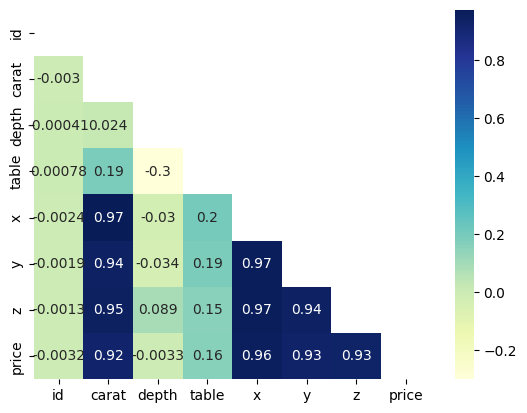

In [4]:
mask = np.triu(np.ones_like(df_diamond.corr()))
sns.heatmap(df_diamond.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

In [5]:
#Im droping id becouse there is no use to it, aswell im droping x,y and z becouse i want to keep as few variables as posible while keeping the most relevant data
#to achive this i compared all of the numeric columns and they are very redundant, x,y and z have the same impact in price as carat, so ill drop these and just keep carat.
#later you'll see in my heatmap why im droping x,y and z.
df_diamond = df_diamond.drop(["id","x","y","z"], axis=1)

In [6]:
df_diamond.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
dtype: int64

In [7]:
df_diamond.duplicated().sum()

444

In [8]:
df_diamond.drop_duplicates(inplace=True)

In [9]:
df_diamond.duplicated().sum()

0

In [10]:
df_diamond.sort_values("price",ascending=False)

,carat,cut,color,clarity,depth,table,price
39601,2.07,Ideal,G,SI2,62.5,55.0,9.842
10629,2.00,Very Good,H,SI1,62.8,57.0,9.842
29519,1.51,Ideal,G,IF,61.7,55.0,9.842
3520,2.00,Premium,I,VS1,60.8,59.0,9.841
7332,2.29,Premium,I,SI1,61.8,59.0,9.841
...,...,...,...,...,...,...,...
34953,0.22,Fair,E,VS2,65.1,61.0,5.820
38044,0.24,Very Good,J,VVS2,62.8,57.0,5.817
33431,0.24,Very Good,I,VVS1,62.3,57.0,5.817
1323,0.31,Good,J,SI2,63.3,58.0,5.814


In [11]:
df_diamond.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price      float64
dtype: object

In [12]:
df_diamond_numeric = df_diamond.select_dtypes(include=np.number)
df_diamond_numeric

,carat,depth,table,price
0,0.30,62.4,58.0,6.353
1,1.01,62.7,56.0,9.183
2,0.72,61.8,59.0,7.983
3,1.08,63.2,57.0,8.371
4,0.36,62.3,59.0,6.588
...,...,...,...,...
40450,0.42,62.1,59.0,6.551
40451,0.53,62.0,58.0,7.382
40452,0.80,62.8,58.0,7.768
40453,1.01,61.5,57.0,8.726


In [13]:
df_diamond_categoric = df_diamond.select_dtypes(include=object)
df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


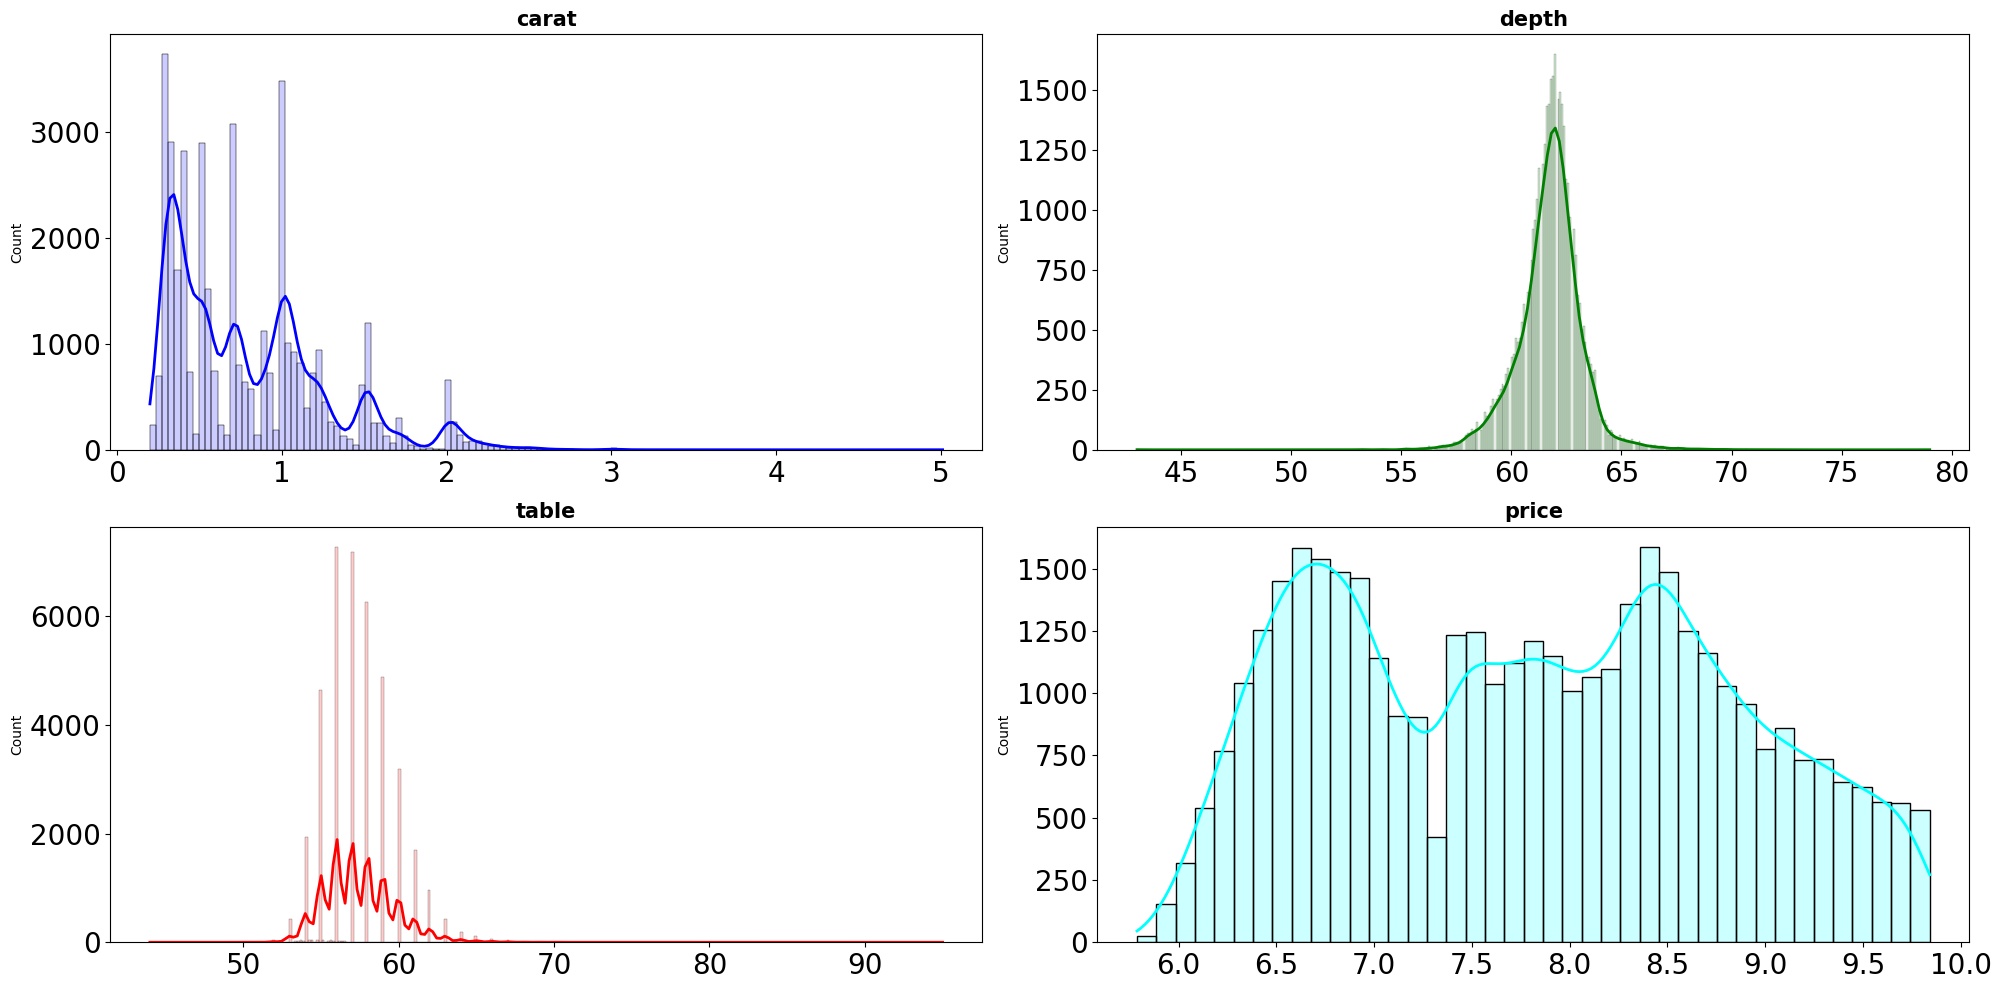

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange","orange","blue","yellow","purple"]

axes = axes.flat

columnas_numeric = df_diamond_numeric.select_dtypes(include = np.number).columns

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df_diamond_numeric,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout();

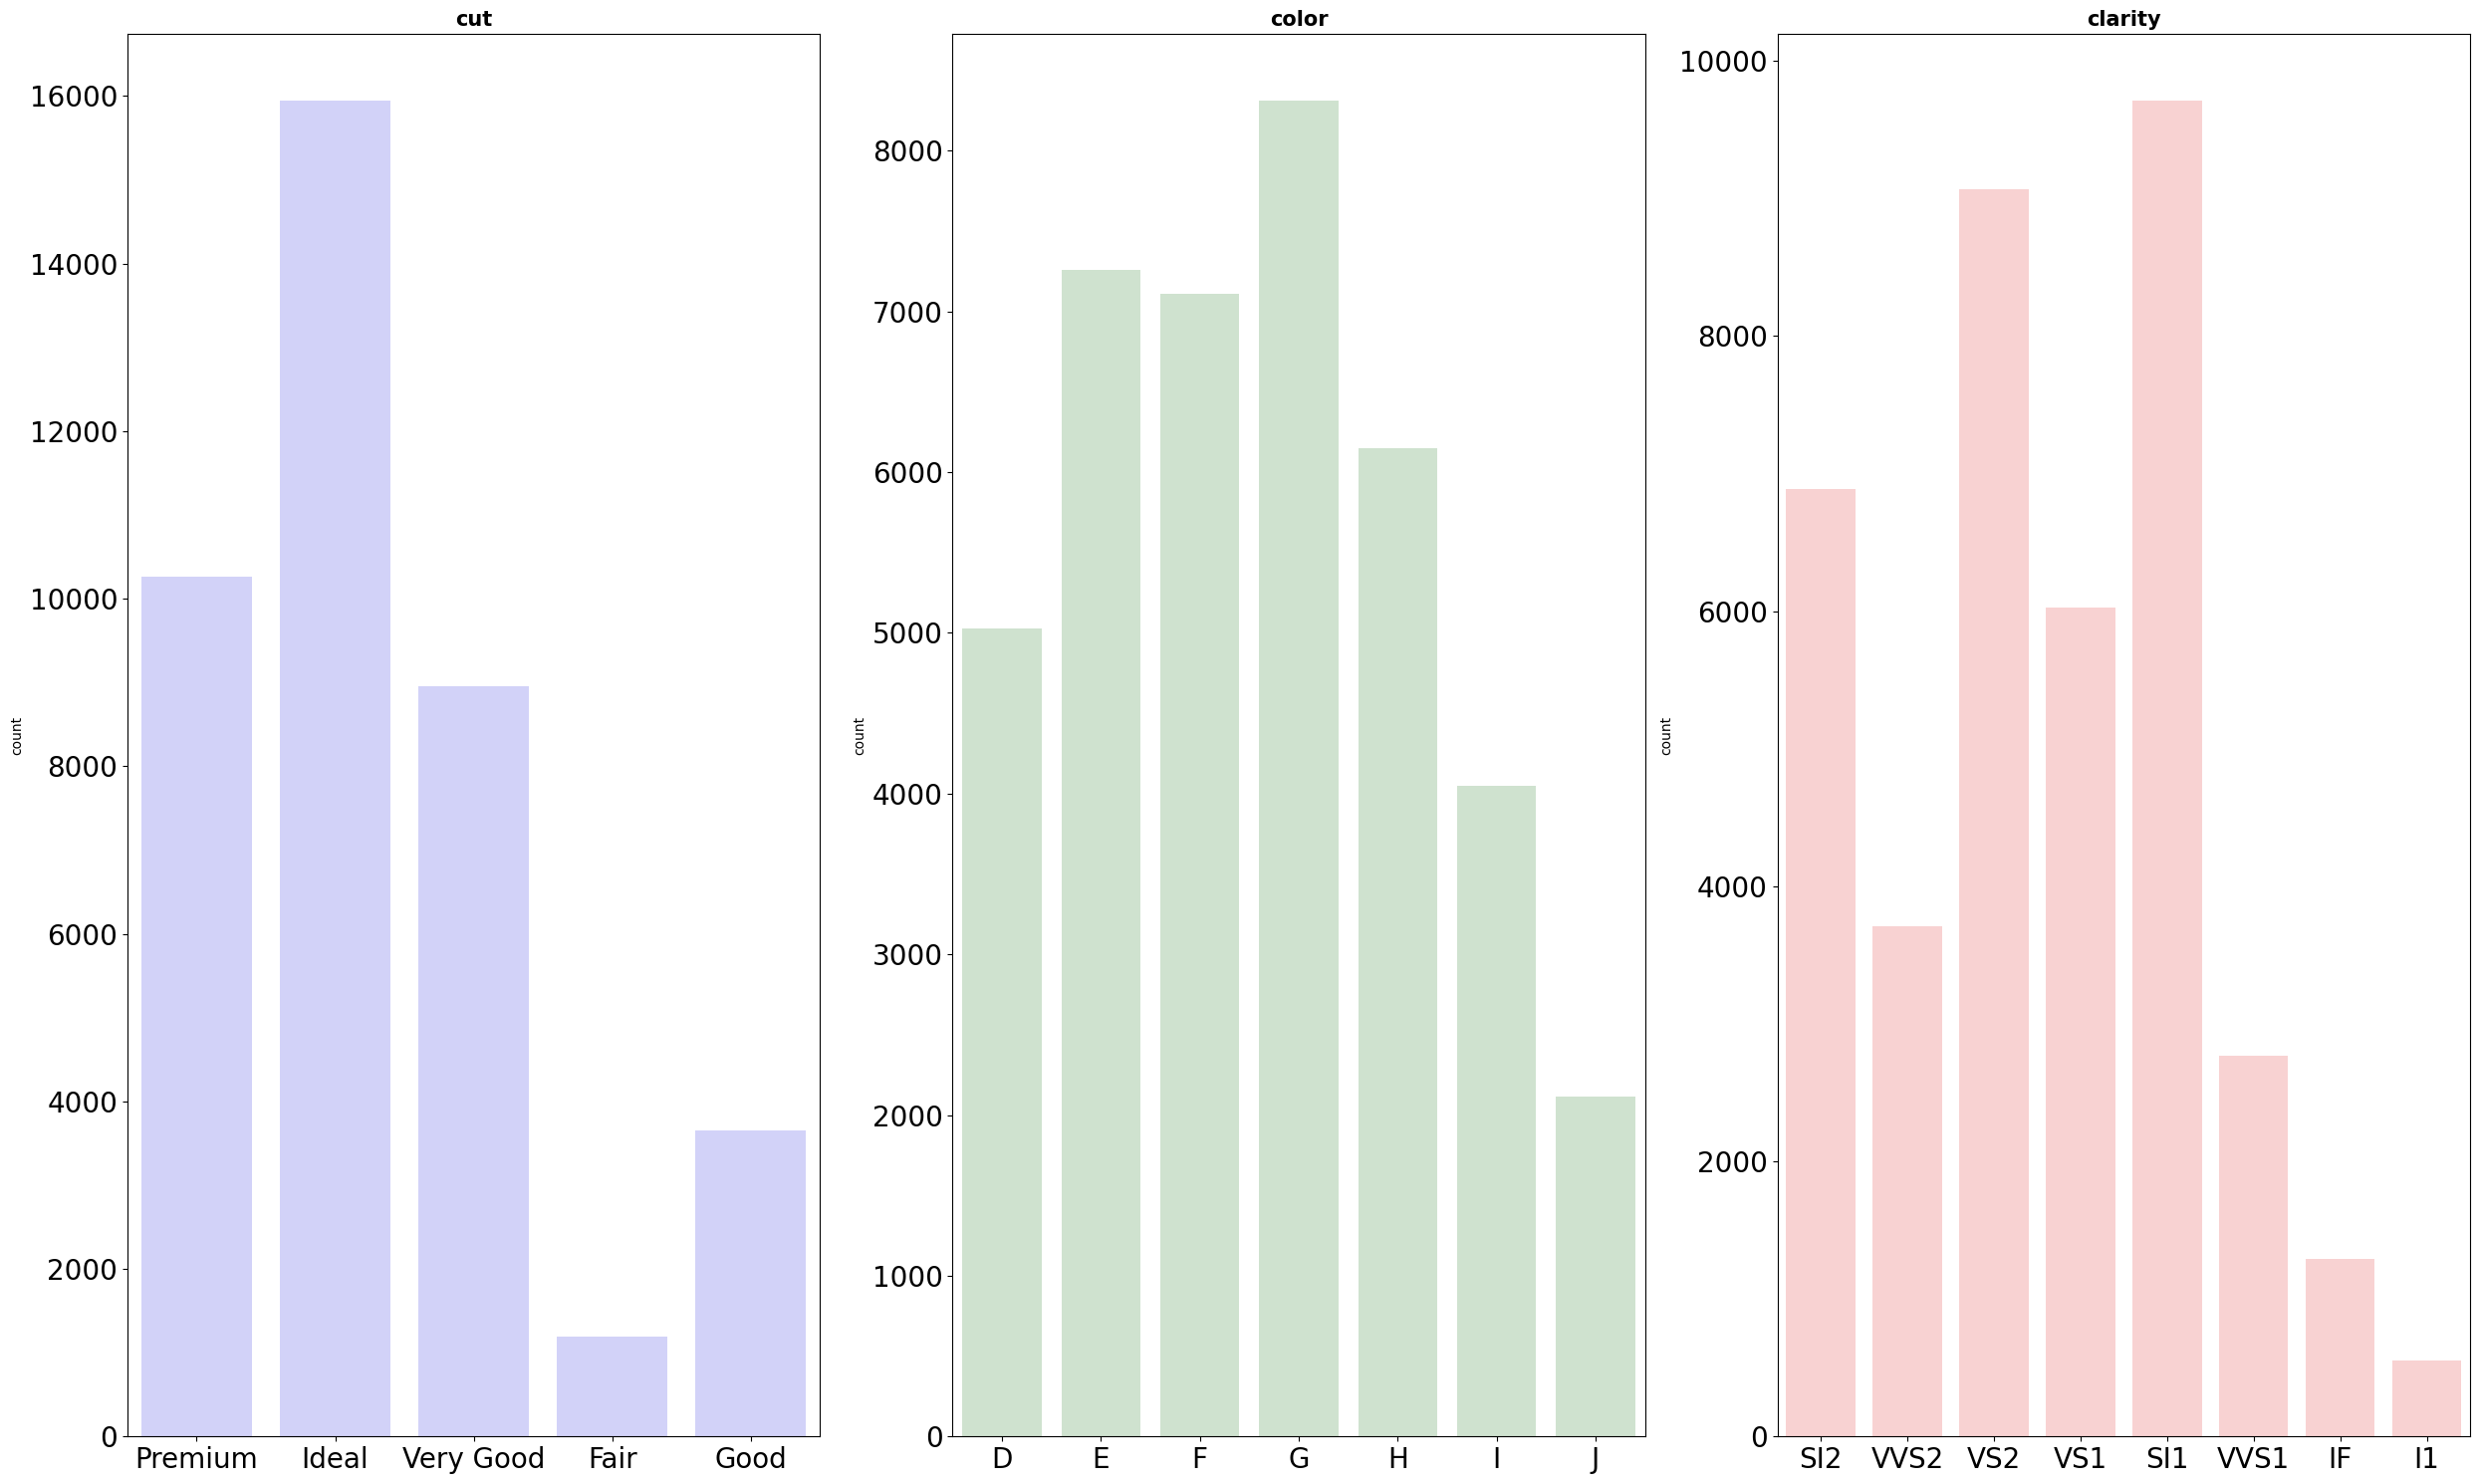

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 15))

lista_colores = ["blue", "green", "red", "magenta", "orange", "yellow", "purple", "gold", "cyan","pink","silver","gray"]

axes = axes.flat

for i, colum in enumerate(df_diamond_categoric): 
    sns.countplot(
        data = df_diamond_categoric,
        x = colum,
        color = lista_colores[i], 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout();

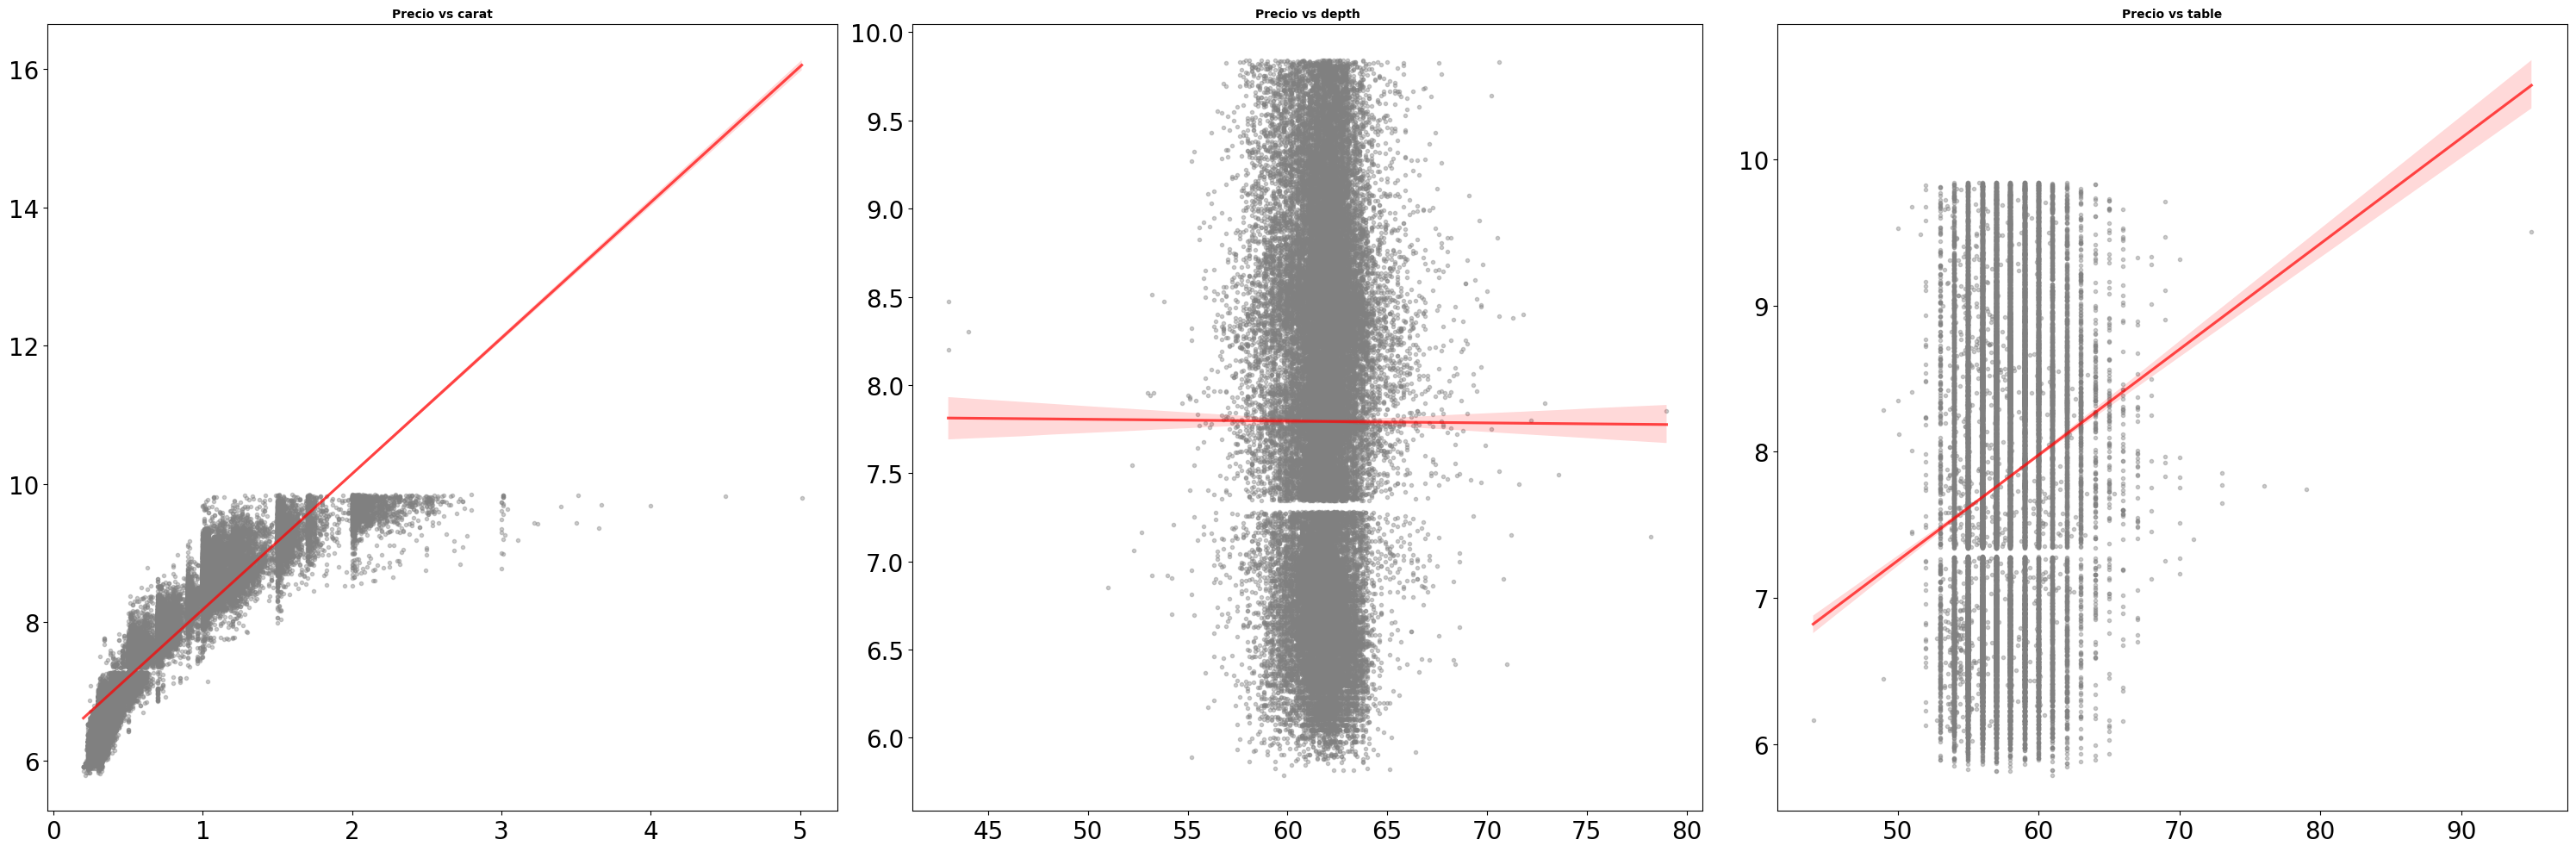

In [16]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df_diamond.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("price")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df_diamond[colum], 
        y = df_diamond["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Precio vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

In [17]:
df_diamond

,carat,cut,color,clarity,depth,table,price
0,0.30,Premium,D,SI2,62.4,58.0,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,8.371
4,0.36,Premium,G,VS1,62.3,59.0,6.588
...,...,...,...,...,...,...,...
40450,0.42,Premium,D,SI2,62.1,59.0,6.551
40451,0.53,Premium,G,VS2,62.0,58.0,7.382
40452,0.80,Good,G,SI2,62.8,58.0,7.768
40453,1.01,Very Good,F,VS2,61.5,57.0,8.726


C:\Users\Sindri\AppData\Local\Temp\ipykernel_70220\641221808.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_diamond.corr()))
C:\Users\Sindri\AppData\Local\Temp\ipykernel_70220\641221808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_diamond.corr(),


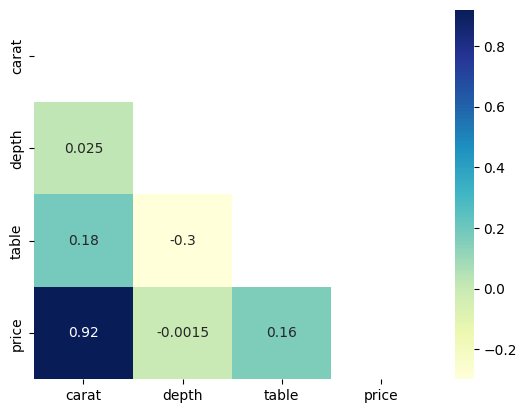

In [18]:
mask = np.triu(np.ones_like(df_diamond.corr()))
sns.heatmap(df_diamond.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

In [19]:
#Here we can see that depth and table are not very tied to price, so ill drop them and just keep carat as it is very relevant.
#I already dropped X Y and Z becouse they give me the exact same metrics as carat, so to simplify the learning model i droped them too.

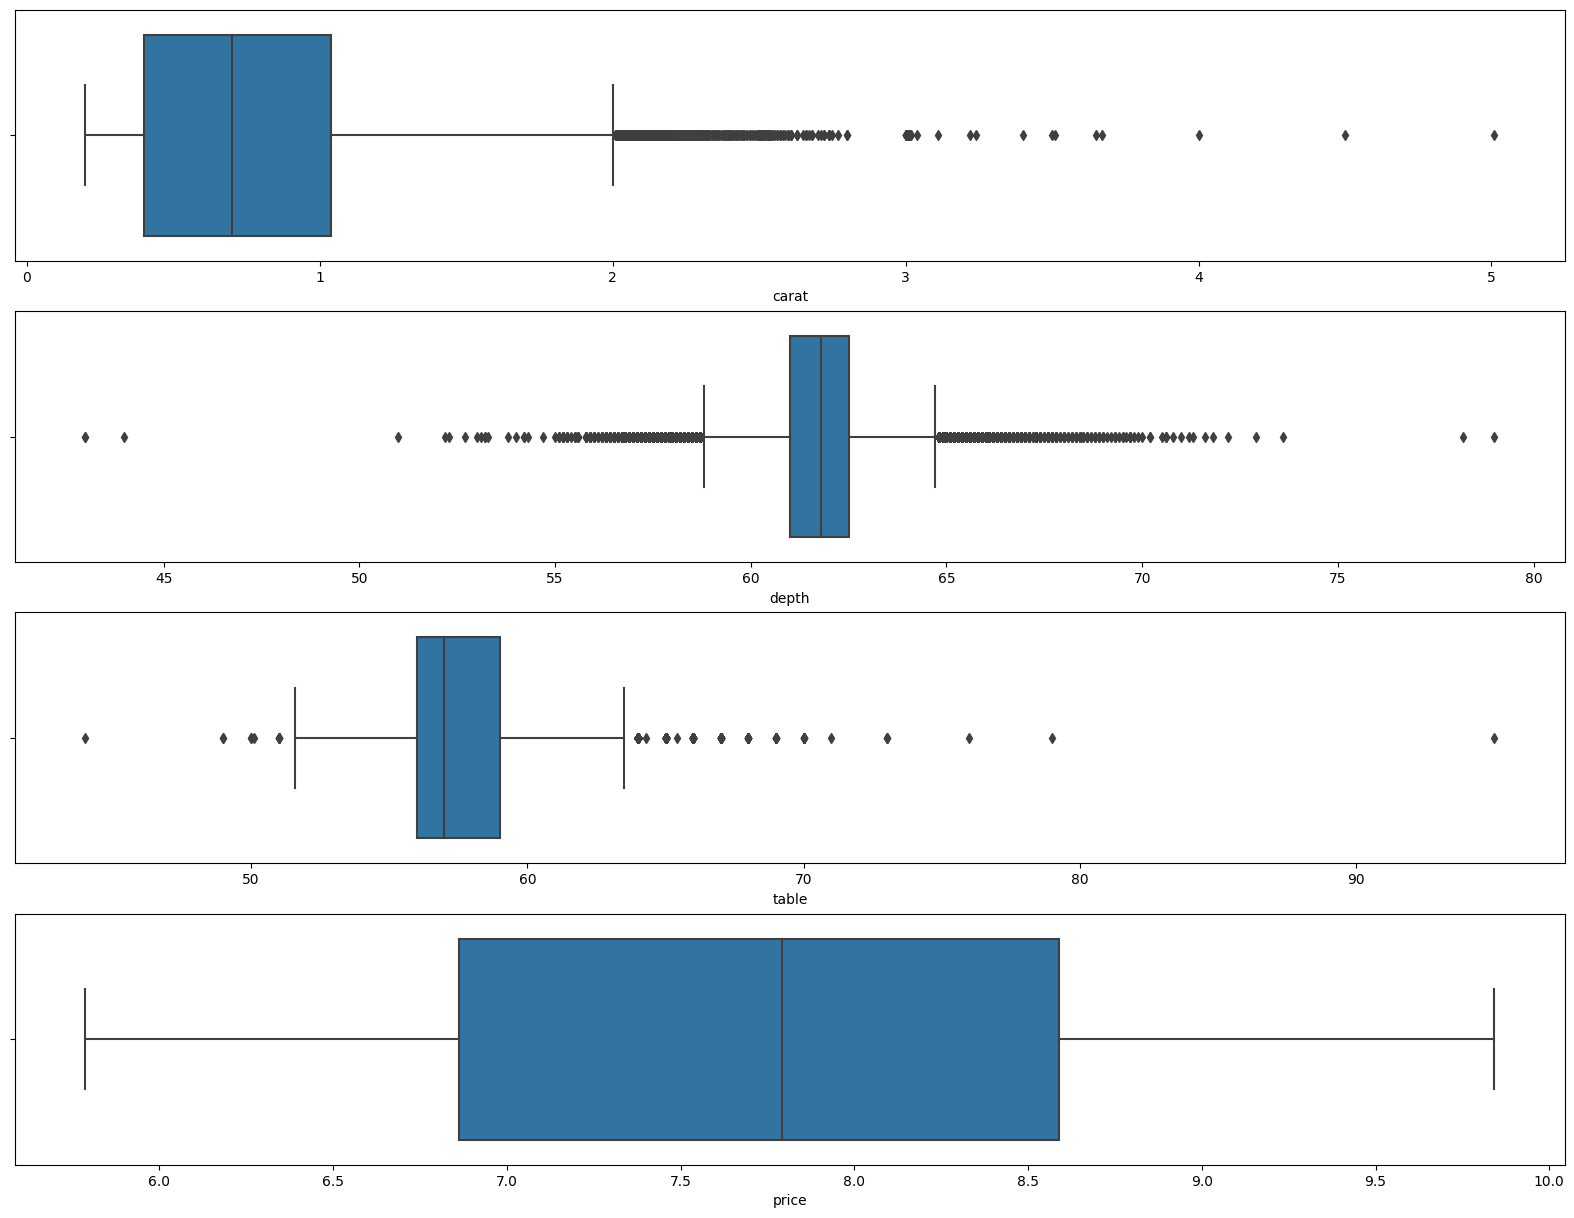

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_diamond_numeric.columns)):
    sns.boxplot(x=df_diamond_numeric.columns[i], data=df_diamond_numeric, ax=ax[i])
plt.show()

In [21]:
carat_outlier = df_diamond_numeric.drop(["depth","table","price"],axis=1)

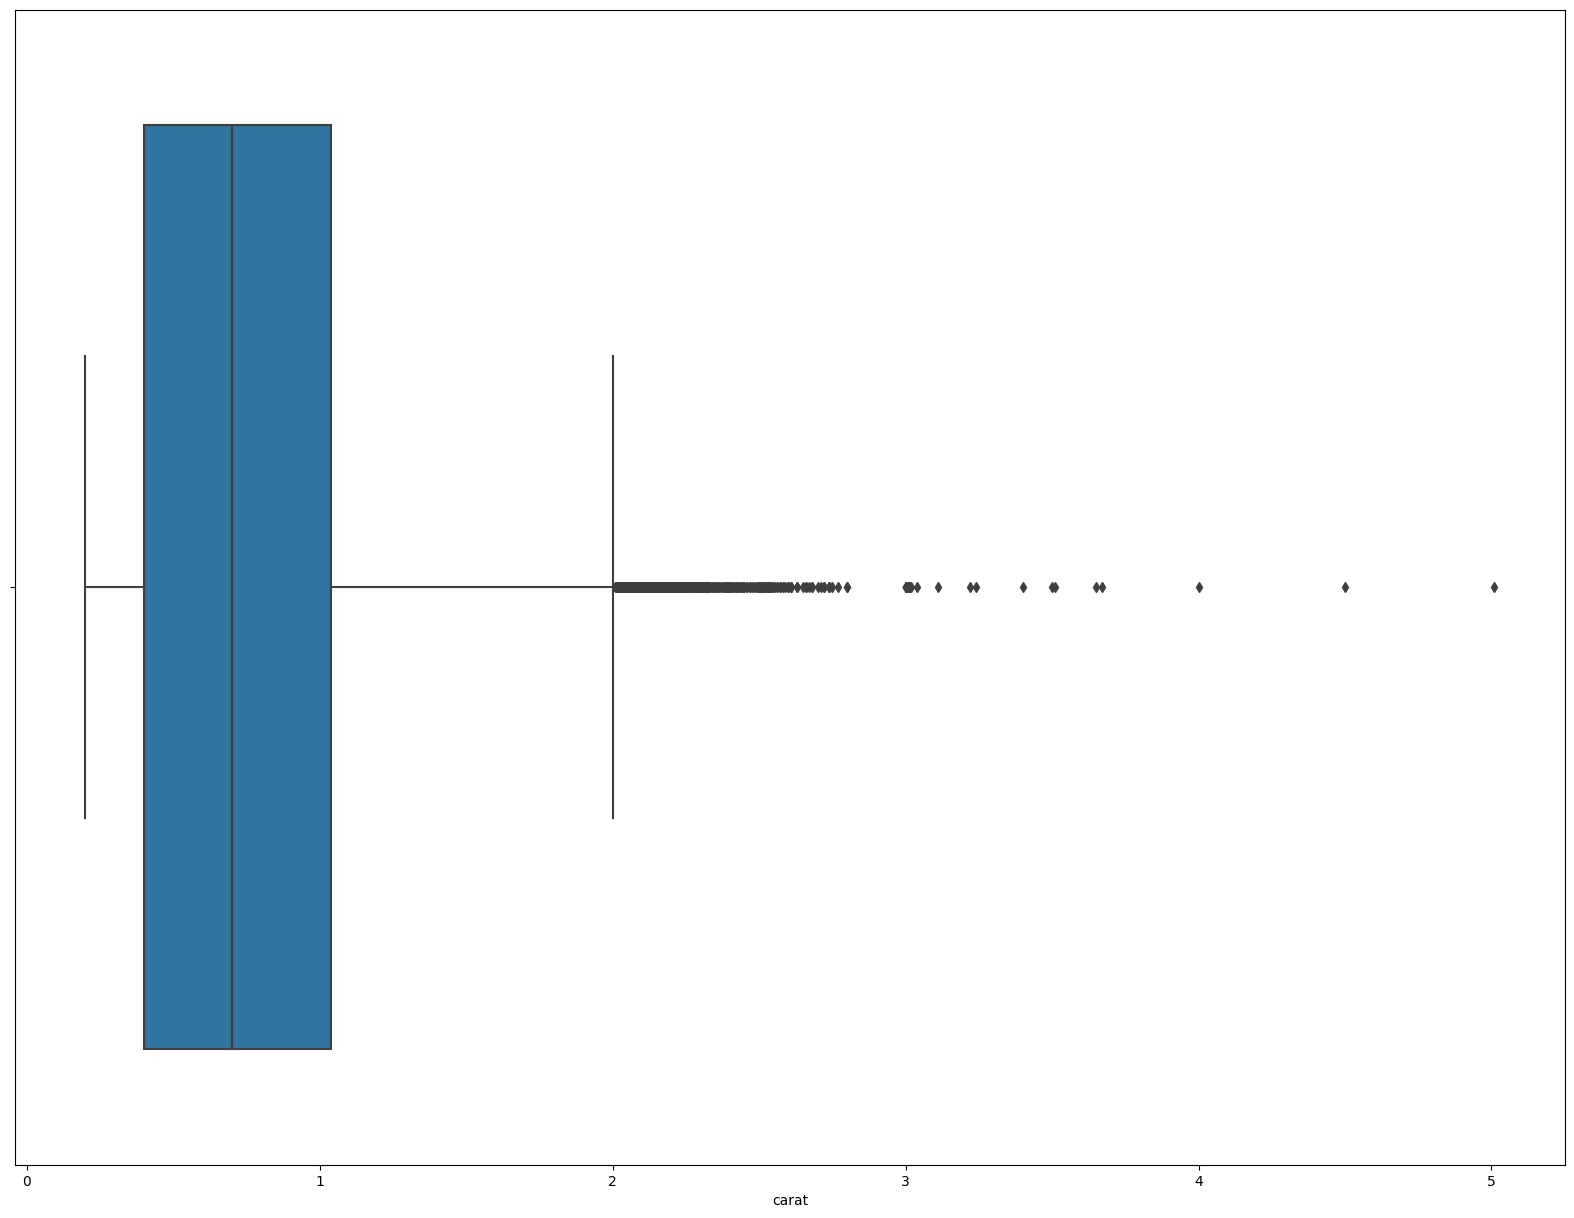

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(20,15))

for i in range(len(carat_outlier.columns)):
    sns.boxplot(x=carat_outlier.columns[i], data=carat_outlier)
plt.show()

In [23]:
#here we can see all the outliers there are in the numeric columns, i only care about carat as it´s the only numeric column im going to keep for the model.

Here we can see how relevant each of the values inside of the categoric columns are, this way i can prepare my ordinal encoder.

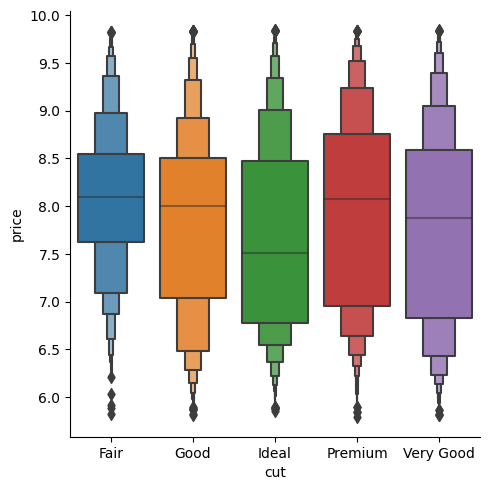

In [24]:
sns.catplot(
    data=df_diamond.sort_values("cut"),
    x="cut", y="price", kind="boxen",
);

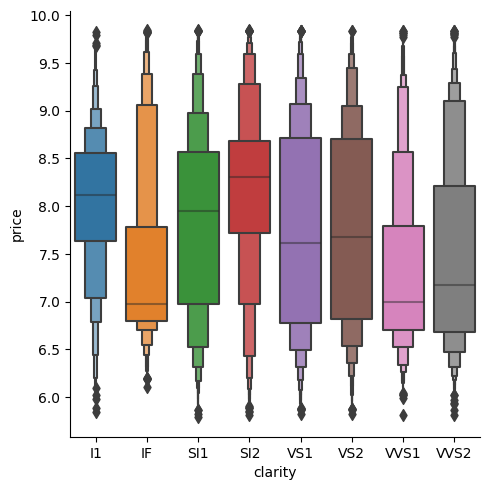

In [25]:
sns.catplot(
    data=df_diamond.sort_values("clarity"),
    x="clarity", y="price", kind="boxen",
);

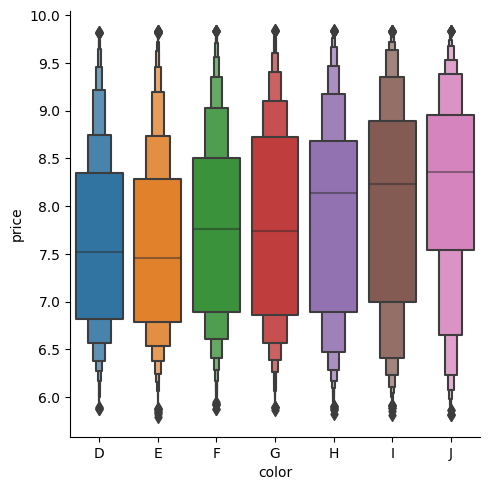

In [26]:
sns.catplot(
    data=df_diamond.sort_values("color"),
    x="color", y="price", kind="boxen",
);

In [27]:
df_diamond

,carat,cut,color,clarity,depth,table,price
0,0.30,Premium,D,SI2,62.4,58.0,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,8.371
4,0.36,Premium,G,VS1,62.3,59.0,6.588
...,...,...,...,...,...,...,...
40450,0.42,Premium,D,SI2,62.1,59.0,6.551
40451,0.53,Premium,G,VS2,62.0,58.0,7.382
40452,0.80,Good,G,SI2,62.8,58.0,7.768
40453,1.01,Very Good,F,VS2,61.5,57.0,8.726


In [28]:
df_diamond_train = df_diamond.drop(["depth","table"], axis = 1)


In [29]:
df_diamond_train

,carat,cut,color,clarity,price
0,0.30,Premium,D,SI2,6.353
1,1.01,Ideal,E,VVS2,9.183
2,0.72,Ideal,F,VS2,7.983
3,1.08,Very Good,G,SI2,8.371
4,0.36,Premium,G,VS1,6.588
...,...,...,...,...,...
40450,0.42,Premium,D,SI2,6.551
40451,0.53,Premium,G,VS2,7.382
40452,0.80,Good,G,SI2,7.768
40453,1.01,Very Good,F,VS2,8.726


In [30]:
df_diamond_numeric.drop(["depth","table"], axis=1, inplace=True)

Standardization.

In [31]:
# Im going to use a robust scaler becouse the numeric column im going to keep has outliers and i dont want to replace them or eliminate them.

In [32]:
df_test = df_diamond_numeric
df_test = df_test.drop("price",axis=1)

In [33]:
robust = RobustScaler()
robust2 = RobustScaler()

In [34]:
lista_num = df_test.columns

In [35]:
robust.fit(df_diamond_numeric[lista_num])



RobustScaler()

In [36]:
X_robust = robust.transform(df_diamond_numeric[lista_num])


In [37]:
df_diamond_numeric[lista_num] = X_robust
df_diamond_numeric

,carat,price
0,-0.625000,6.353
1,0.484375,9.183
2,0.031250,7.983
3,0.593750,8.371
4,-0.531250,6.588
...,...,...
40450,-0.437500,6.551
40451,-0.265625,7.382
40452,0.156250,7.768
40453,0.484375,8.726


In [38]:
with open('data/estandarizacion_modelo2.pkl', 'wb') as s:
    pickle.dump(robust, s)

Encoding

In [39]:
#For this first model ill use a label encoder and see how the results are, later ill do a ordinal encoder based on the importance of the categoric columns.

In [40]:
df_diamond["clarity"].value_counts()

SI1     9709
VS2     9068
SI2     6887
VS1     6026
VVS2    3710
VVS1    2769
IF      1289
I1       553
Name: clarity, dtype: int64

In [41]:
cut_order = ["Ideal","Good","Fair","Very Good","Premium"]
clarity_order = ["IF","VVS1","VVS2","I1","SI1","SI2","VS2","VS1"]
color_order = ["E","D","F","H","G","I","J"]

In [42]:
ordinal_cut = OrdinalEncoder(categories = [cut_order], dtype = int)
cut_transformed = ordinal_cut.fit_transform(df_diamond_categoric[["cut"]])
df_cut_transformed = pd.DataFrame(cut_transformed)
df_cut_transformed = df_cut_transformed.rename(columns={0:"cut"})
with open(f'data/encoding_cut.pkl', 'wb') as s:
    pickle.dump(ordinal_cut, s) 


In [43]:
ordinal_clarity = OrdinalEncoder(categories = [clarity_order], dtype = int)
clarity_transformed = ordinal_clarity.fit_transform(df_diamond_categoric[["clarity"]])
df_clarity_transformed = pd.DataFrame(clarity_transformed)
df_clarity_transformed = df_clarity_transformed.rename(columns={0:"clarity"})
with open(f'data/encoding_clarity.pkl', 'wb') as s:
    pickle.dump(ordinal_clarity, s) 

In [44]:
ordinal_color = OrdinalEncoder(categories = [color_order], dtype = int)
color_transformed = ordinal_color.fit_transform(df_diamond_categoric[["color"]])
df_color_transformed = pd.DataFrame(color_transformed)
df_color_transformed = df_color_transformed.rename(columns={0:"color"})
with open(f'data/encoding_color.pkl', 'wb') as s:
    pickle.dump(ordinal_color, s) 

In [45]:
df_diamond_categoric.drop(["cut","color","clarity"],axis=1,inplace=True)

In [46]:
df_diamond_categoric = pd.concat([df_cut_transformed,df_color_transformed,df_clarity_transformed],axis=1)
df_diamond_categoric = df_diamond_categoric.rename(columns={0:"cut",0:"color",0:"clarity"})
df_diamond_categoric

,cut,color,clarity
0,4,1,5
1,0,0,2
2,0,2,6
3,3,4,5
4,4,4,7
...,...,...,...
40006,4,1,5
40007,4,4,6
40008,1,4,5
40009,3,2,6


In [47]:
df_diamond_numeric= df_diamond_numeric.reset_index()

In [48]:
df_diamond_numeric = df_diamond_numeric.drop("index",axis=1)

In [49]:
df_diamond_numeric

,carat,price
0,-0.625000,6.353
1,0.484375,9.183
2,0.031250,7.983
3,0.593750,8.371
4,-0.531250,6.588
...,...,...
40006,-0.437500,6.551
40007,-0.265625,7.382
40008,0.156250,7.768
40009,0.484375,8.726


In [50]:
df_diamond_limpio = pd.concat([df_diamond_numeric,df_diamond_categoric],axis=1)
df_diamond_limpio

,carat,price,cut,color,clarity
0,-0.625000,6.353,4,1,5
1,0.484375,9.183,0,0,2
2,0.031250,7.983,0,2,6
3,0.593750,8.371,3,4,5
4,-0.531250,6.588,4,4,7
...,...,...,...,...,...
40006,-0.437500,6.551,4,1,5
40007,-0.265625,7.382,4,4,6
40008,0.156250,7.768,1,4,5
40009,0.484375,8.726,3,2,6


In [51]:
#This is a 80% train 20% test model just to test and see metrics.
X = df_diamond_limpio.drop('price', axis =1)
y = df_diamond_limpio['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

In [52]:
#This is a 100% train model that ill use to predict the test data.
X2 = df_diamond_limpio.drop('price', axis =1)
y2 = df_diamond_limpio['price']

In [53]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [54]:
#First ill try a decission tree.

# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [55]:
max_features = np.sqrt(len(X_train.columns))
max_features

2.0

In [56]:
print(regressor.tree_.max_depth)

26


In [57]:
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [58]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.087285,0.014117,0.118815,0.986154,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I


In [59]:
#This is again a Decission Tree but with custom params.

param = {"max_depth": [12,13,14],
        "min_samples_split": [5,10,15,20,25],
        "max_features": [4,5,6]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [60]:
%time
gs.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [12, 13, 14], 'max_features': [4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [61]:
best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=14, max_features=5, min_samples_split=20)

In [62]:
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)

In [63]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")

In [64]:
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.082755,0.011941,0.109275,0.988288,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II


In [65]:
df_all = pd.concat([dt_results1, dt_results2], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.087285,0.014117,0.118815,0.986154,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I
0,0.082755,0.011941,0.109275,0.988288,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II


In [66]:
#Now ill try a random forest, usually this model gives very good metrics.

param = {"max_depth": [12,13,14],
        "min_samples_split": [5,10,15,20,25],
        "max_features": [4,5,6]}

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [67]:
%time
bosque.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [12, 13, 14], 'max_features': [4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [68]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=13, max_features=5, min_samples_split=10)

In [69]:
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [70]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.079616,0.010971,0.104741,0.989240,test,Random Forest
1,0.070306,0.008521,0.092312,0.991761,train,Random Forest


In [71]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.087285,0.014117,0.118815,0.986154,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I
0,0.082755,0.011941,0.109275,0.988288,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II
0,0.079616,0.010971,0.104741,0.989240,test,Random Forest
1,0.070306,0.008521,0.092312,0.991761,train,Random Forest


In [72]:
#And as my last predicting model ill use a Gradient booster, the can take a while but are very powerfull.


param = {"max_depth": [6,7,8,9],
        "min_samples_split": [40,45,50],
        "max_features": [5,6,7,8]}

grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(),
        param_grid = param,
        n_jobs     = -1,
        verbose    = 1,
        cv         = 10, 
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9],
                         'max_features': [5, 6, 7, 8],
                         'min_samples_split': [40, 45, 50]},
             return_train_score=True, verbose=1)

In [73]:
grad = grid.best_estimator_
grad

GradientBoostingRegressor(max_depth=7, max_features=5, min_samples_split=50)

In [74]:
y_pred_gb_test= grid.predict(X_test)
y_pred_gb_train= grid.predict(X_train)

In [75]:
results_gradient = metricas(y_test,  y_train, y_pred_gb_test, y_pred_gb_train, "Gradient")
results_gradient

,MAE,MSE,RMSE,R2,set,modelo
0,0.076951,0.010288,0.101429,0.989909,test,Gradient
1,0.072559,0.009110,0.095445,0.991192,train,Gradient


In [76]:
df_all_results = pd.concat([df_all, results_gradient], axis = 0)
df_all_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.087285,0.014117,0.118815,0.986154,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I
0,0.082755,0.011941,0.109275,0.988288,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II
0,0.079616,0.010971,0.104741,0.989240,test,Random Forest
1,0.070306,0.008521,0.092312,0.991761,train,Random Forest
0,0.076951,0.010288,0.101429,0.989909,test,Gradient
1,0.072559,0.009110,0.095445,0.991192,train,Gradient


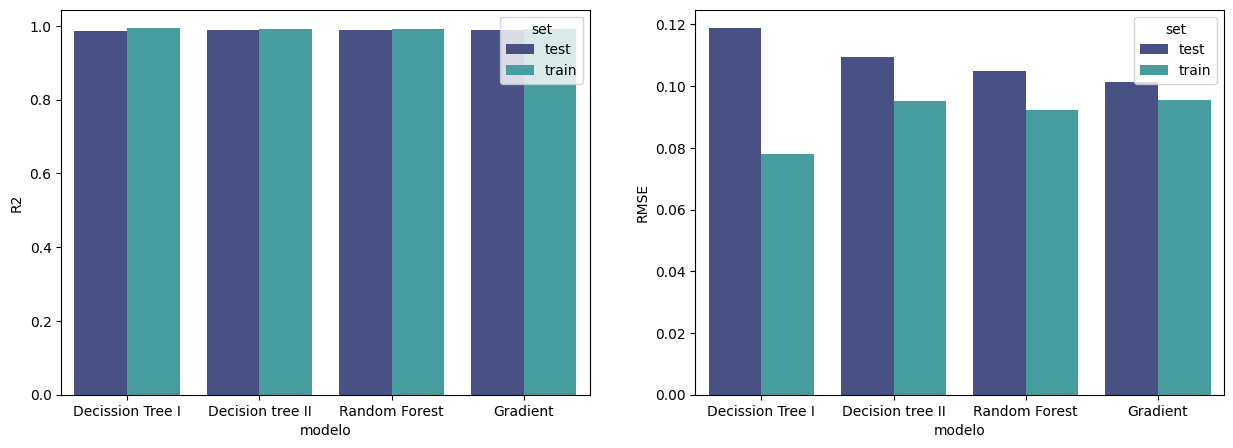

In [77]:
fig, axes = plt.subplots(1,2, figsize =(15,5))

sns.barplot(data = df_all_results, x = "modelo", y = "R2", hue = "set", ax = axes[0], palette="mako")
sns.barplot(data = df_all_results, x = "modelo", y = "RMSE", hue = "set",ax = axes[1], palette = "mako");

I'll use again gradient as it's the most precise model and the least overfitted.

In [78]:
param = {"max_depth": [6,7,8,9],
        "min_samples_split": [40,45,50],
        "max_features": [5,6,7,8]}
grid2 = GridSearchCV(
        estimator  = GradientBoostingRegressor(),
        param_grid = param,
        n_jobs     = -1,
        verbose    = 1,
        cv         = 10, 
        return_train_score = True
       )

grid2.fit(X = X2, y = y2)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9],
                         'max_features': [5, 6, 7, 8],
                         'min_samples_split': [40, 45, 50]},
             return_train_score=True, verbose=1)

In [79]:
with open('data/mejor_modelo2.pkl', 'wb') as modelo:
        pickle.dump(grid2, modelo)